In [1]:
import torch
import torch.nn as nn

from models.kinematic_model.kinematic_model import KinematicModel
from models.timing_model.timing_model import TimingModel
from models.spatial_model.spatial_model import SpatialModel
import models.spatial_model.sm_config as sm_config
from models.robot_visualizer.robot_visualizer import RobotVisualizer
import task_specifications.tasks as tasks
import task_specifications.utils.operation_types as operation_types
import task_specifications.utils.operation_sequences as operation_sequences

In [2]:
km = KinematicModel()
tm = TimingModel()
sm = SpatialModel()
rv = RobotVisualizer()

In [3]:
# helper function to generate joint position given grid position
def grid_to_joint_position(grid_position):
	x, y, z = grid_position
	return km.compute_inverse_kinematics(sm.compute_spatial_pose(x, y, z))

In [4]:
def generate_timed_task_matrix(task, initial_grid_position=(0, 0, 0)):
	x, y, z = initial_grid_position
	start_joint_position = grid_to_joint_position((x, y, z))
	task_matrix = []
	for operation in task:
		if isinstance(operation, operation_types.Move):
			x_t, y_t, z_t= operation.x, operation.y, operation.table_distance
			joint_position = grid_to_joint_position((x_t, y_t, z_t))
			time = tm.compute_duration_between_jps(start_joint_position, joint_position)
			task_matrix.append([*start_joint_position, *joint_position, time])
			start_joint_position = joint_position
		elif isinstance(operation, operation_types.Grip):
			task_matrix.append([*start_joint_position, *start_joint_position, 1.1])
		elif isinstance(operation, operation_types.MoveGripper):
			task_matrix.append([*start_joint_position, *start_joint_position, 1.1])
	return task_matrix    

In [5]:
def generate_trajectory(timed_task_matrix):
    trajectory = []
    for op in timed_task_matrix:
        start = op[:6]
        end = op[6:12]
        t = op[12]
        no_steps = t/0.05
        # trajectory_segment = jtraj(start, end, no_steps)
        trajectory_segment = km.compute_trajectory(start.detach().numpy(), end.detach().numpy(), t.detach().numpy())
        trajectory.append(torch.tensor(trajectory_segment.q, dtype=torch.float32))
    return torch.cat(trajectory, dim=0)

In [6]:
def generate_random_task(max_blocks=8, x_min=-5, x_max=10, y_min=-9, y_max=9):
	task = []
	no_blocks = torch.randint(1, max_blocks, (1,)).item()
	for _ in range(no_blocks):
		x_origin = torch.randint(x_min, x_max, (1,)).item()
		y_origin = torch.randint(y_min, y_max, (1,)).item()
		x_target = torch.randint(x_min, x_max, (1,)).item()
		y_target = torch.randint(y_min, y_max, (1,)).item()

		task.extend(operation_sequences.move_and_grip(x_origin, y_origin))
		task.extend(operation_sequences.move_and_release(x_target, y_target))
	return task  

In [7]:
def generate_random_task(max_blocks=8, valid_regions=sm_config.VALID_REGIONS):
    """Generate a random task with positions constrained to valid regions."""
    task = []
    no_blocks = torch.randint(1, max_blocks, (1,)).item()

    for _ in range(no_blocks):
        # Select a region randomly for origin
        region_origin = valid_regions[torch.randint(0, len(valid_regions), (1,)).item()]
        x_origin, y_origin = generate_point_in_region(region_origin)

        # Select a region randomly for target
        region_target = valid_regions[torch.randint(0, len(valid_regions), (1,)).item()]
        x_target, y_target = generate_point_in_region(region_target)

        # Add operations for origin and target points
        task.extend(operation_sequences.move_and_grip(x_origin, y_origin))
        task.extend(operation_sequences.move_and_release(x_target, y_target))

    return task

def generate_point_in_region(region):
    """Generate a random point within a given region."""
    if isinstance(region, sm_config.Rectangle):
        x = torch.randint(region.xmin, region.xmax + 1, (1,)).item()
        y = torch.randint(region.ymin, region.ymax + 1, (1,)).item()
        return x, y
    elif isinstance(region, sm_config.Triangle):
        return generate_point_in_triangle_barycentric(region)

def generate_point_in_triangle_barycentric(triangle):
    """Generate a random point inside a triangle using barycentric coordinates."""
    v1, v2, v3 = triangle.v1, triangle.v2, triangle.v3

    # Generate two random numbers in [0, 1]
    u = torch.rand(1).item()
    v = torch.rand(1).item()

    # Ensure the point lies within the triangle by flipping coordinates if needed
    if u + v > 1:
        u, v = 1 - u, 1 - v

    # Compute the random point using the triangle's vertices and barycentric weights
    x = (1 - u - v) * v1[0] + u * v2[0] + v * v3[0]
    y = (1 - u - v) * v1[1] + u * v2[1] + v * v3[1]

    return int(round(x)), int(round(y))


# Data generation

In [8]:
# generate random tasks
generated_tasks = [generate_random_task() for _ in range(150)]

# generate timed task matrix for each task
# these can fail if the task is not feasible (grid positions are not reachable)
timed_task_matrices = []
failed_tasks = 0
for task in generated_tasks:
	try:
		timed_task_matrix = torch.tensor(generate_timed_task_matrix(task), dtype=torch.float32)
	except Exception as e:
		failed_tasks += 1
		continue
	timed_task_matrices.append(timed_task_matrix)
    
print(f"Failed tasks: {failed_tasks}/{len(generated_tasks)}")

# generate trajectory for each task
trajectories = [generate_trajectory(timed_task_matrix) for timed_task_matrix in timed_task_matrices]


Failed tasks: 27/150


In [30]:
# generate targets for each task with small noise
target_timed_task_matrices = []
for timed_task_matrix in timed_task_matrices:
	target_timed_task_matrix = timed_task_matrix.clone()
	target_timed_task_matrix[:, 12] += torch.abs(torch.randn_like(timed_task_matrix[:, 12]) * 0.03)
	target_timed_task_matrices.append(target_timed_task_matrix)

# generate noisy trajectories for each task
noisy_trajectories = [generate_trajectory(target_timed_task_matrix) for target_timed_task_matrix in target_timed_task_matrices]

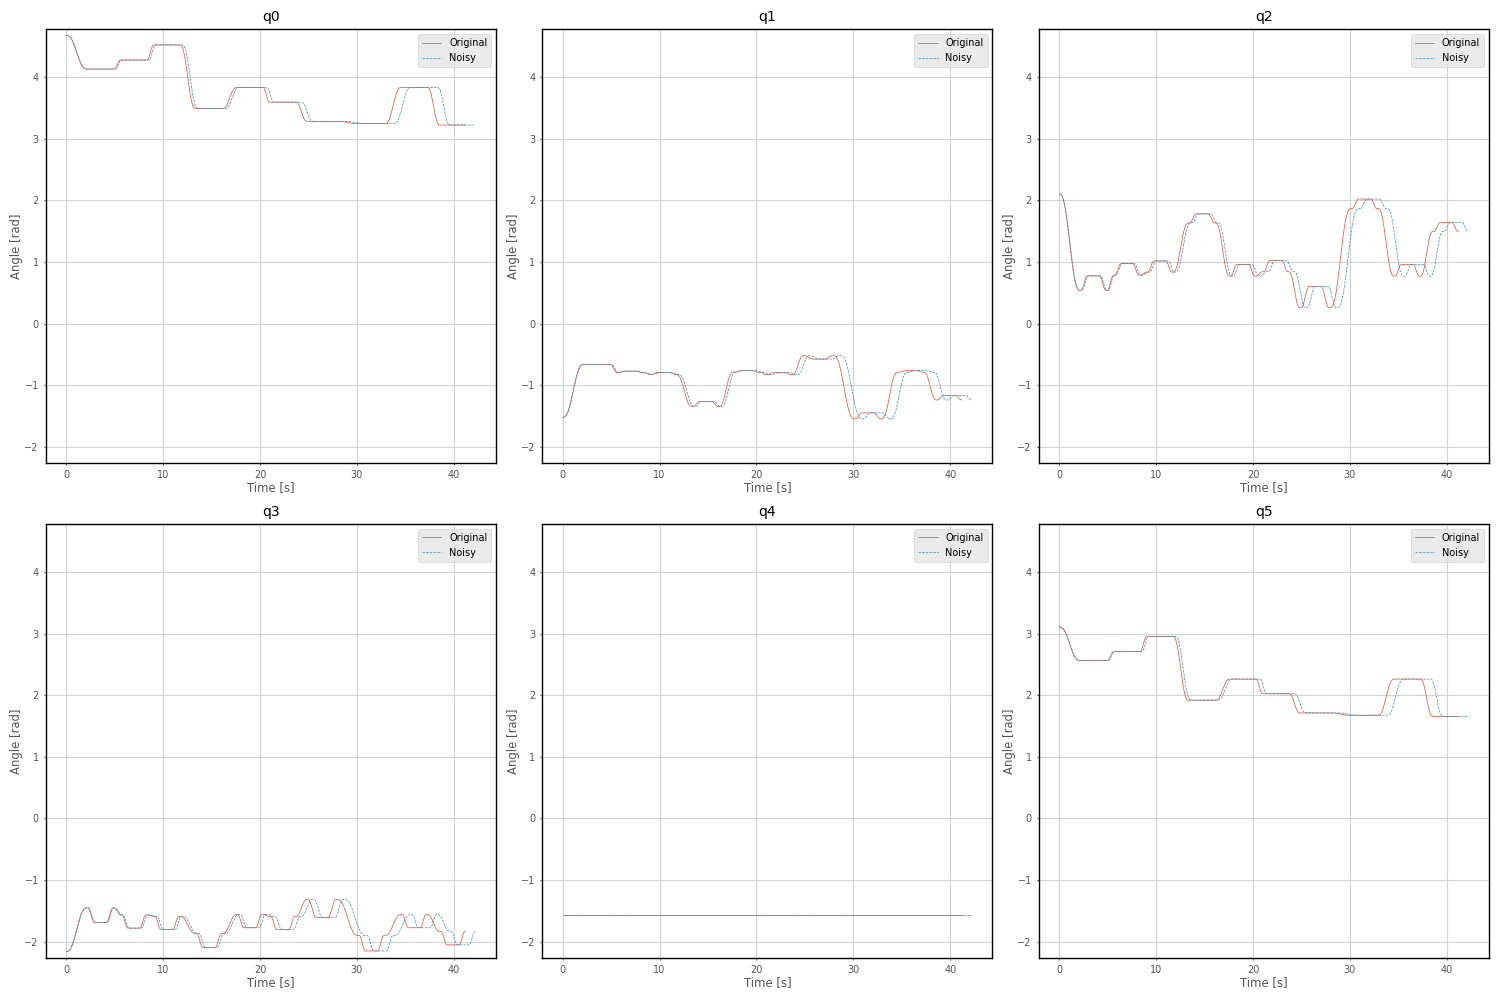

In [31]:
# show pairwise comparison of two trajectories
sample_trajectory = trajectories[0]
sample_noisy_trajectory = noisy_trajectories[0]
rv.plot_trajectory_2d([sample_trajectory.numpy(), sample_noisy_trajectory.numpy()], ["Original", "Noisy"])

In [105]:
# example task
task = tasks.two_blocks

# generate timed task matrix
timed_task_matrix = torch.tensor(generate_timed_task_matrix(task, (0,0,0)), dtype=torch.float32, requires_grad=True)
timed_task_matrix_noisy = timed_task_matrix.clone()

timed_task_matrix_noisy[:, 12] = timed_task_matrix_noisy[:, 12] + torch.abs(torch.randn_like(timed_task_matrix[:, 12]) * 0.1)

# generate trajectory
trajectory_noisy = generate_trajectory(timed_task_matrix_noisy)
trajectory = generate_trajectory(timed_task_matrix)

In [106]:
# print shape and type info
print("timed_task_matrix shape: ", timed_task_matrix.shape)
print("timed_task_matrix type: ", timed_task_matrix.dtype)
print("trajectory shape: ", trajectory.shape)
print("trajectory type: ", trajectory.dtype)
print("trajectory_noisy shape: ", trajectory_noisy.shape)
print("trajectory_noisy type: ", trajectory_noisy.dtype)

timed_task_matrix shape:  torch.Size([16, 13])
timed_task_matrix type:  torch.float32
trajectory shape:  torch.Size([353, 6])
trajectory type:  torch.float32
trajectory_noisy shape:  torch.Size([374, 6])
trajectory_noisy type:  torch.float32


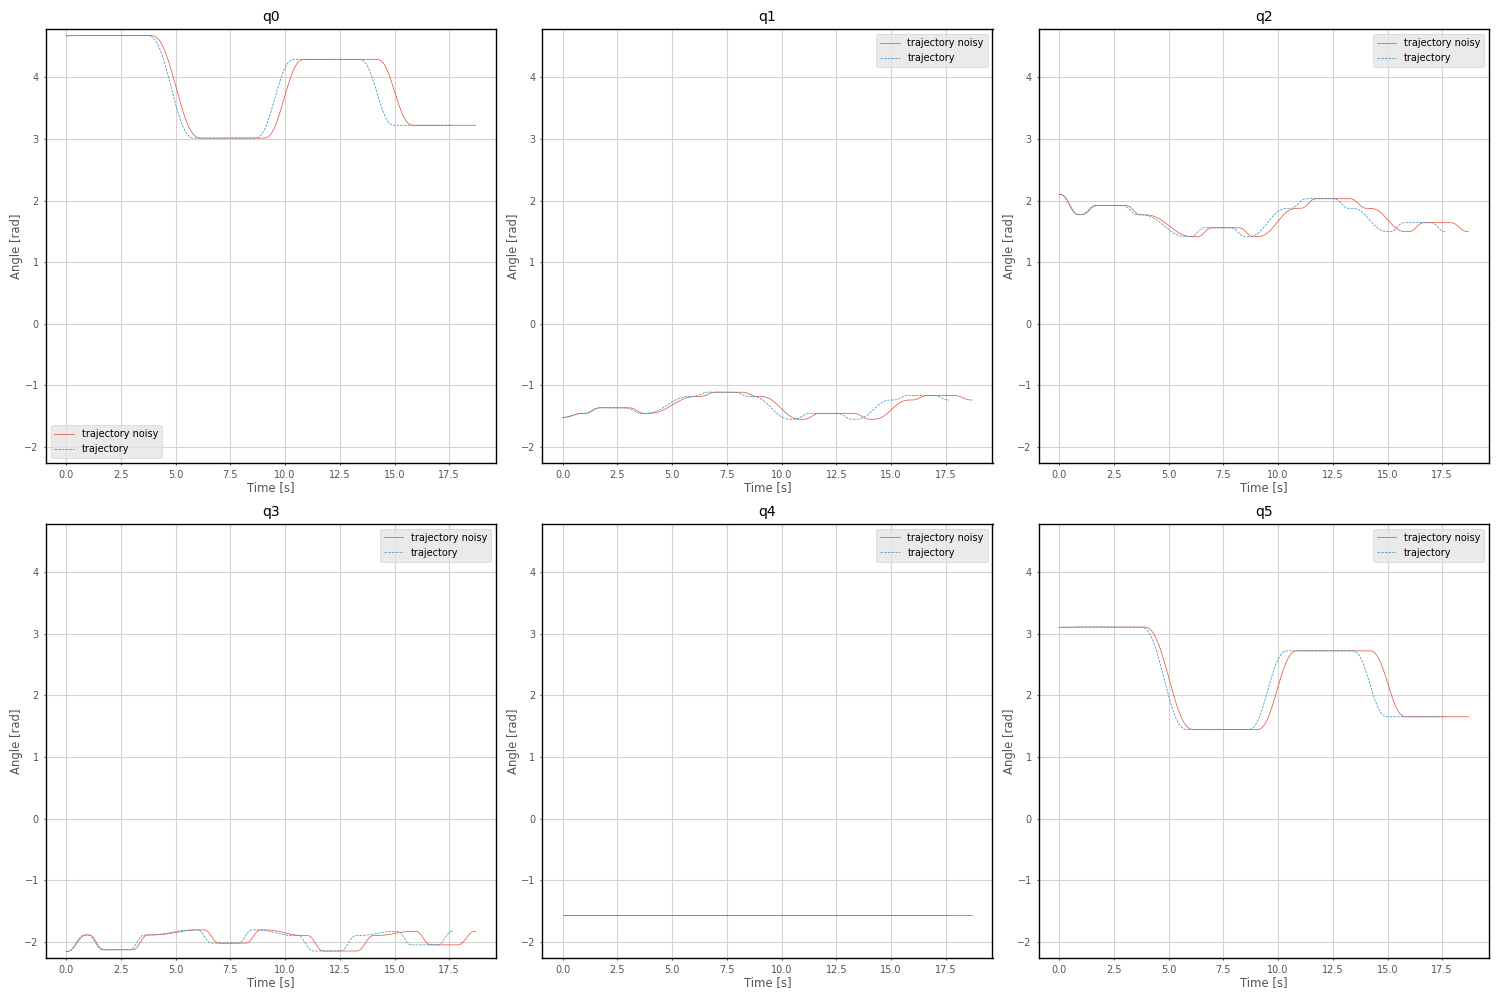

In [ ]:
# plot
rv.plot_trajectory_2d([trajectory_noisy.detach().numpy(), trajectory.detach().numpy()], ["trajectory noisy", "trajectory"])

In [101]:
# see if leaf
print("timed_task_matrix is leaf: ", timed_task_matrix.is_leaf)
print("trajectory_noisy is leaf: ", trajectory_noisy.is_leaf)
print("trajectory is leaf: ", trajectory.is_leaf)

timed_task_matrix is leaf:  True
trajectory_noisy is leaf:  True
trajectory is leaf:  True


In [62]:
class TimingOffsetModel(nn.Module):
	def __init__(self, 
			  input_size=6, 
			  hidden_size=128, 
			  num_layers=2,
			  dropout=0.2):
		super(TimingOffsetModel, self).__init__()

		# LSTM layer for sequence processing
		self.lstm = nn.LSTM(input_size, 
					  hidden_size, 
					  num_layers, 
					  batch_first=True,
					  bidirectional=True,
					  dropout=dropout)
		
		# Fully connected layers after the LSTM for the final output
		self.fc1 = nn.Linear(hidden_size*2, hidden_size * 2)
		self.fc2 = nn.Linear(hidden_size * 2, hidden_size * 4)
		self.fc3 = nn.Linear(hidden_size * 4, input_size)  # Output is the same size as input (trajectory point)
		
		self.relu = nn.ReLU()
		
	def forward(self, x):
		# Get the last value of the tensor
		last_value = x[-1].unsqueeze(0)  # Shape (1, features)

		# Repeat the last value to create the padding
		padding = last_value.repeat(30, 1)  # Shape (pad_size, features)

		# Concatenate the original tensor with the padding
		x = torch.cat([x, padding], dim=0)  # Shape (seq_len + pad_size, features)

		# Pass through LSTM
		lstm_out, _ = self.lstm(x)  # Output from LSTM

		# Pass through fully connected layers for each time step
		x = self.fc1(lstm_out)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.fc3(x)

		return x

In [63]:
# instantiate model
model = TimingOffsetModel()

# example forward pass
output = model(sample_trajectory)
print("input shape: ", sample_trajectory.shape)
print("output shape: ", output.shape)

input shape:  torch.Size([824, 6])
output shape:  torch.Size([854, 6])


In [ ]:
def train_model(model, criterion, optimizer, inputs, outputs, num_epochs=1000):
	# Ensure both data and model are on the same device
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"Training on {device}")
	model.to(device)
	
	for epoch in range(num_epochs):
		model.train()
		epoch_loss = 0

		for input, target in zip(inputs, outputs):
			# Forward pass
			output = model(input)

			# Ensure trajectory lengths match
			with torch.no_grad():
				min_len = min(output.size(0), target.size(0))
				target_slices = target[:min_len]
			output_slices = output[:min_len]

			# Compute the loss
			loss = criterion(output_slices, target_slices)

			# Backward pass
			optimizer.zero_grad()
			loss.backward(retain_graph=True)  # Ensure the graph is retained if needed
			optimizer.step()

			epoch_loss += loss.item()

		# Output the loss for every 10 epochs
		if (epoch + 1) % 10 == 0:
			print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(inputs)}')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, trajectories, noisy_trajectories, num_epochs=100)


Epoch 10/100, Loss: 0.010316568576329486
Epoch 20/100, Loss: 0.006892815302315403


Failed attempts: 0


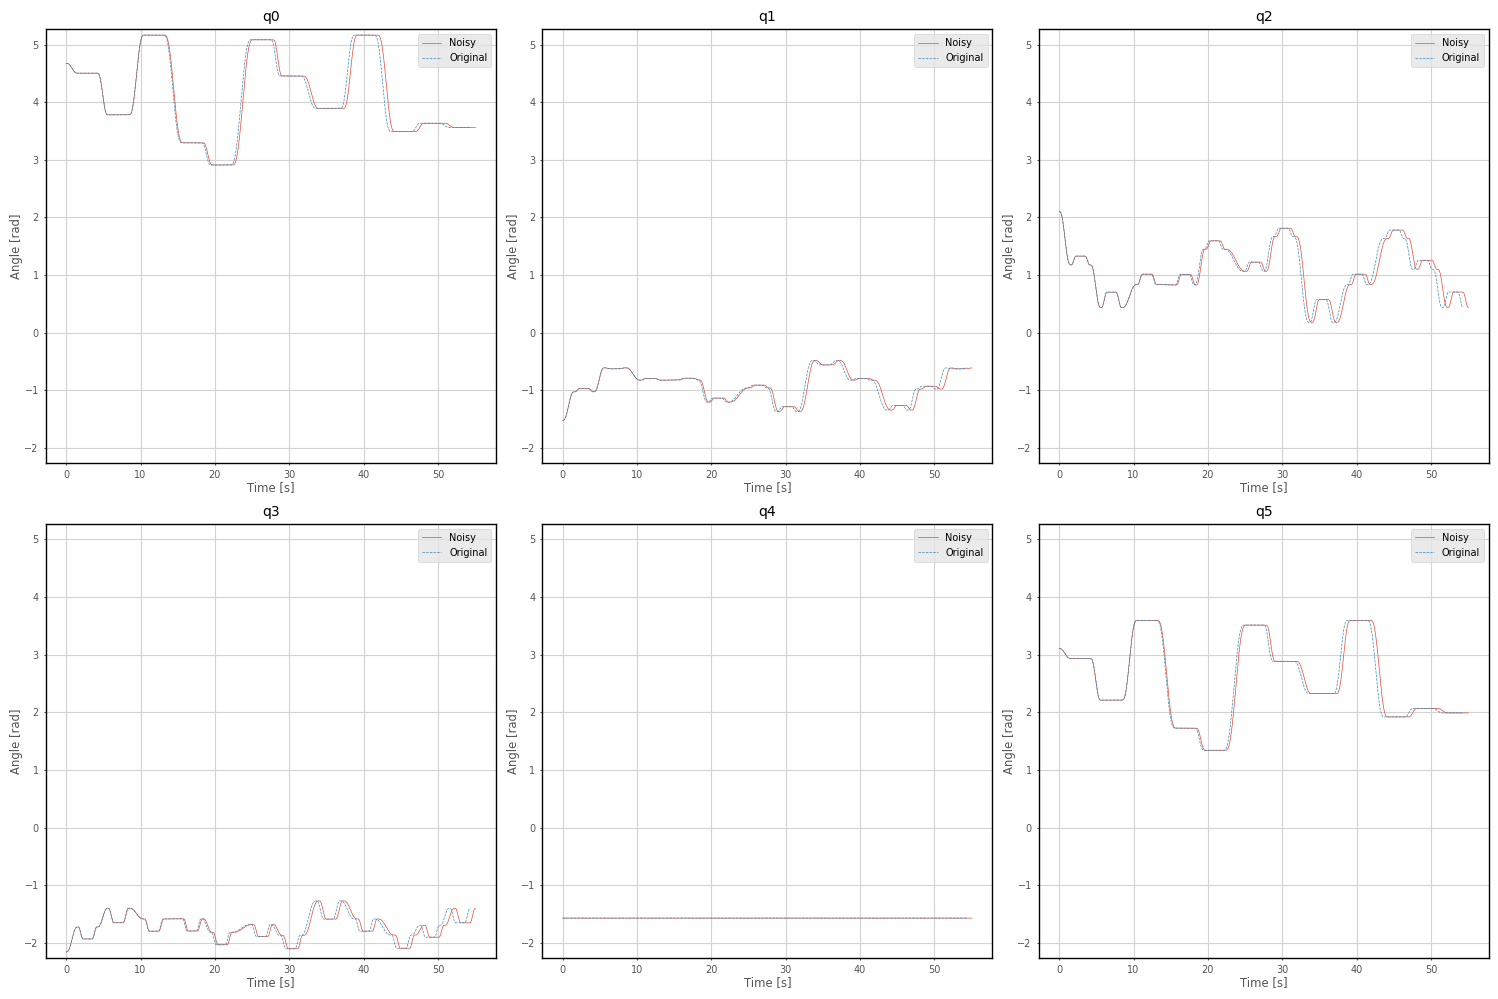

In [46]:
# test on new random task
task_successfull = False
failed_attempts = 0

while not task_successfull:
	new_task = generate_random_task()
	try:
		new_timed_task_matrix = torch.tensor(generate_timed_task_matrix(new_task), dtype=torch.float32)
		new_trajectory = generate_trajectory(new_timed_task_matrix)
		task_successfull = True
	except Exception as e:
		failed_attempts += 1
		continue

print(f"Failed attempts: {failed_attempts}")

# noisy trajectory
new_target_timed_task_matrix = new_timed_task_matrix.clone()
new_target_timed_task_matrix[:, 12] += torch.abs(torch.randn_like(new_timed_task_matrix[:, 12]) * 0.03)
new_noisy_trajectory = generate_trajectory(new_target_timed_task_matrix)

# plot
rv.plot_trajectory_2d([new_noisy_trajectory.detach().numpy(), new_trajectory.detach().numpy()], ["Noisy", "Original"])

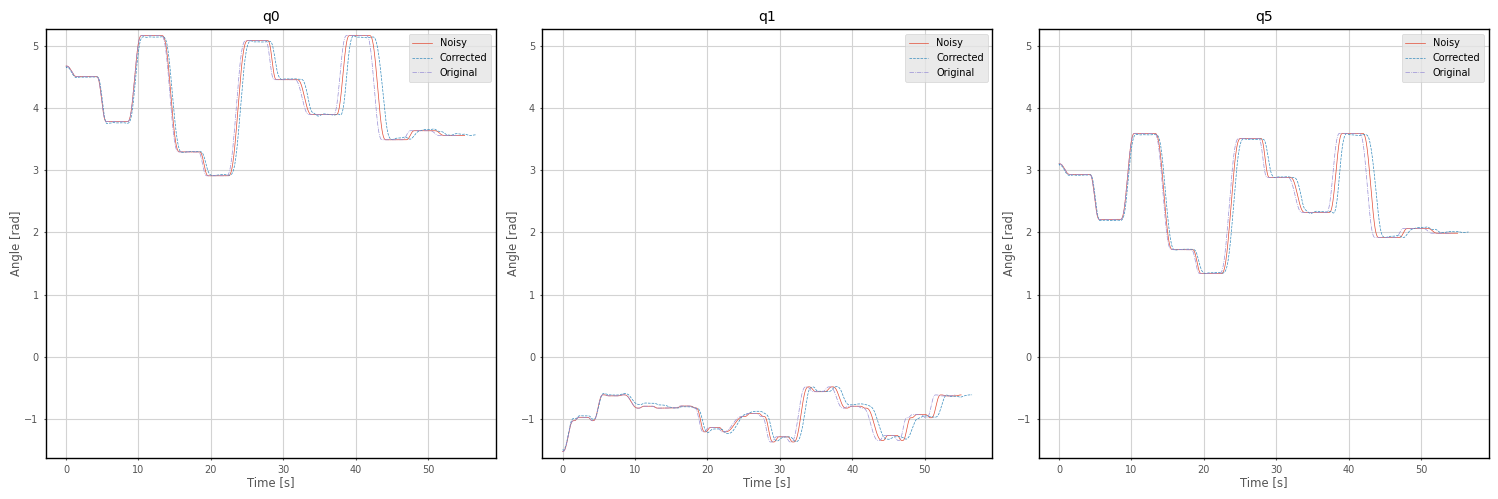

In [49]:
# predict corrected trajectory
model.eval()
corrected_trajectory = model(new_noisy_trajectory)

# plot
rv.plot_trajectory_2d([new_noisy_trajectory.detach().numpy(), corrected_trajectory.detach().numpy(), new_trajectory.detach().numpy()], 
                      ["Noisy", "Corrected", "Original"],
                      [0, 1, 5])